                   timestamp  current_mA  voltage_V  power_active_W  \
0 2025-02-26 18:10:05.943973         318        232              59   
1 2025-02-26 18:10:06.938554         316        232              59   
2 2025-02-26 18:10:07.939856         316        232              59   
3 2025-02-26 18:10:08.939446         354        231              67   
4 2025-02-26 18:10:09.942393         374        231              73   

   energy_counter_Wh  node run  
0                 14  riga   0  
1                  0  riga   0  
2                  0  riga   0  
3                  0  riga   0  
4                  0  riga   0  


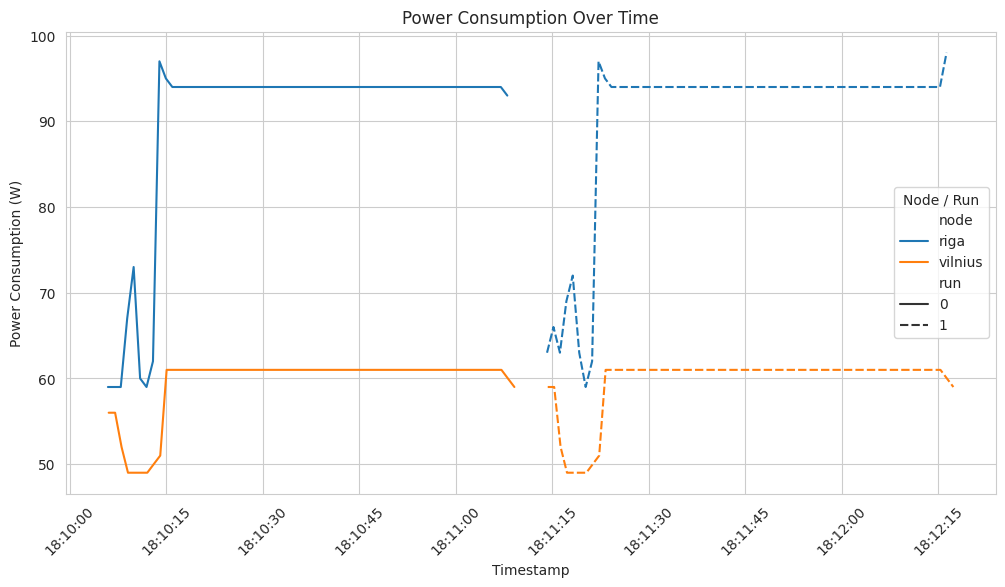

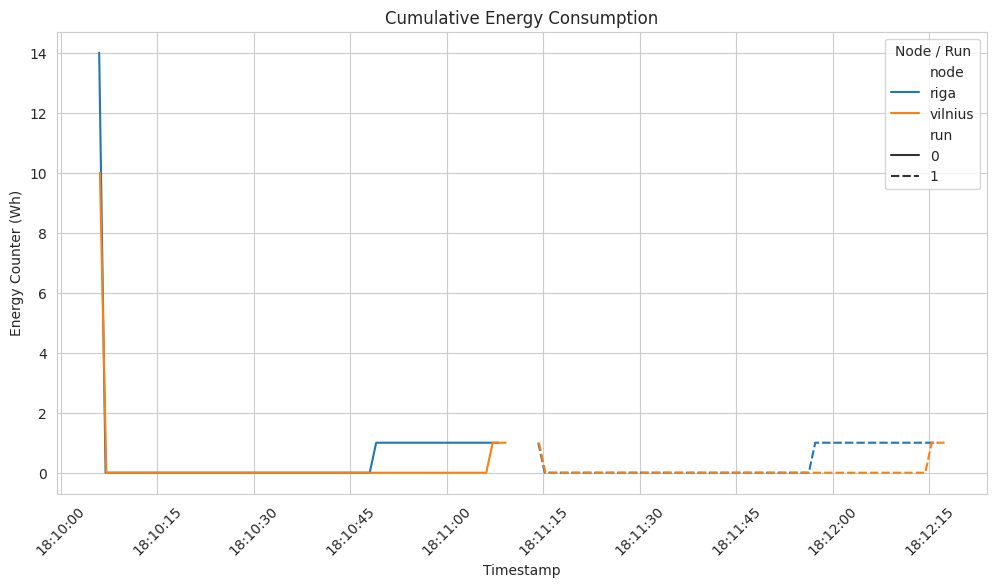

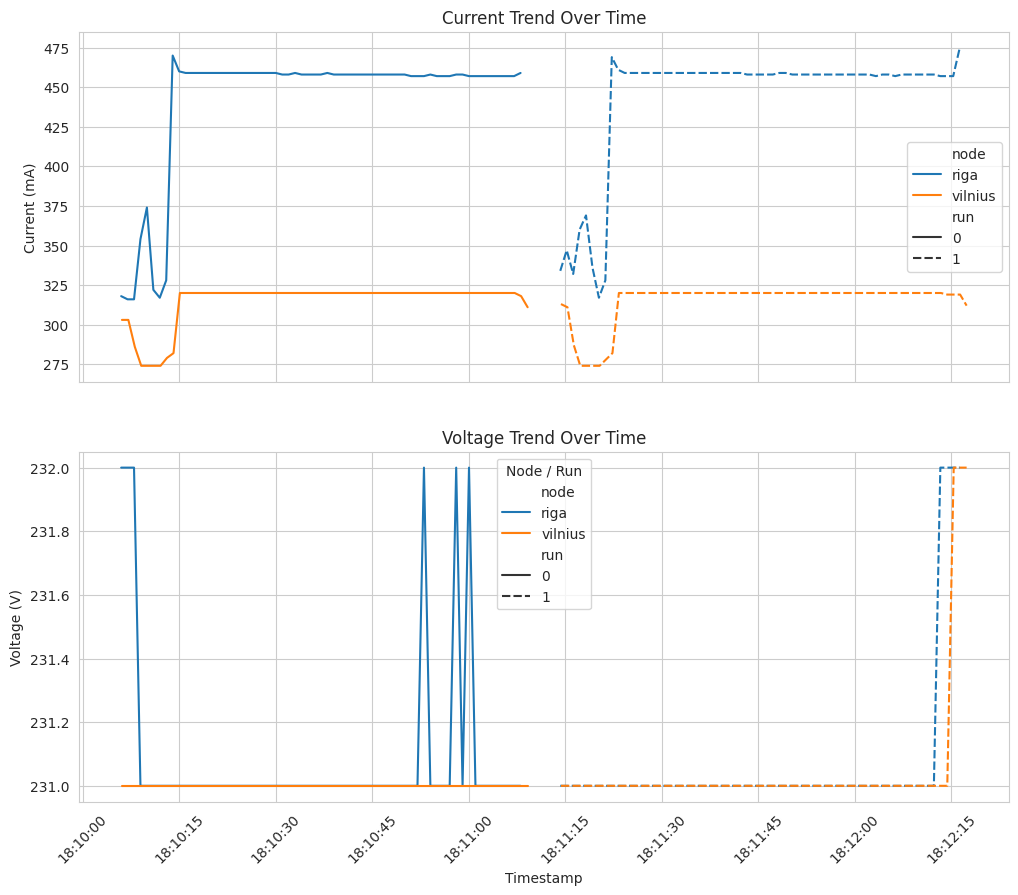

Node: Testbed Node riga, FQDN: riga.baltikum.net.cit.tum.de
Topology Data:
{
    "vilnius.baltikum.net.cit.tum.de": [
        {
            "inf_a": "enp4s0f0",
            "inf_b": "enp2s0f0",
            "mac_a": "90:e2:ba:1c:55:54",
            "mac_b": "a0:36:9f:54:c1:70",
            "type": "link",
            "properties": {
                "speed": "1000BaseTFD - Four-pair Category 5 UTP, full duplex mode",
                "device_b": "server"
            }
        },
        {
            "inf_a": "enp4s0f1",
            "inf_b": "enp2s0f1",
            "mac_a": "90:e2:ba:1c:55:55",
            "mac_b": "a0:36:9f:54:c1:71",
            "type": "link",
            "properties": {
                "speed": "1000BaseTFD - Four-pair Category 5 UTP, full duplex mode",
                "device_b": "server"
            }
        },
        {
            "inf_a": "enp6s0f0",
            "inf_b": "enp2s0f2",
            "mac_a": "90:e2:ba:1c:55:56",
            "mac_b": "a0:36:9f:54:c1:7

In [5]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

RESULT_FOLDER = "/srv/testbed/results/warmuth/default/2025-02-26_18-06-05_836417"

def load_energy_data():
    """
    Load all CSV files from the energy folder inside the result folder.
    Each node has its own subfolder containing multiple _runXX.csv files.
    """
    energy_folder = os.path.join(RESULT_FOLDER, "energy")
    if not os.path.exists(energy_folder):
        raise FileNotFoundError(f"Energy folder not found: {energy_folder}")

    all_data = []

    # Iterate over each node folder
    for node in os.listdir(energy_folder):
        node_path = os.path.join(energy_folder, node)
        if os.path.isdir(node_path):
            for file in os.listdir(node_path):
                if file.endswith(".csv") and "_run" in file:
                    file_path = os.path.join(node_path, file)
                    df = pd.read_csv(file_path)
                    df["timestamp"] = df["timestamp"].apply(lambda x: datetime.strptime(str(x), "%Y%m%d%H%M%S%f"))
                    df["node"] = node
                    df["run"] = file.split("_run")[-1].split(".")[0]  # Extract run number
                    all_data.append(df)

    if not all_data:
        raise ValueError("No valid CSV files found in the energy folder.")

    return pd.concat(all_data, ignore_index=True)

def load_rocrate_metadata():
    """
    Load and parse the RO-Crate metadata JSON file.
    Extract node information based on keywords and read topology files.
    """
    rocrate_path = os.path.join(RESULT_FOLDER, "ro-crate-metadata.json")
    if not os.path.exists(rocrate_path):
        raise FileNotFoundError(f"RO-Crate metadata file not found: {rocrate_path}")

    with open(rocrate_path, "r") as f:
        metadata = json.load(f)

    nodes_info = []

    for item in metadata.get("@graph", []):
        if "keywords" in item and "node" in item["keywords"]:
            topology_path = os.path.join(RESULT_FOLDER, item.get("topology", {}).get("@id", "Unknown"))
            topology_data = "Not available"
            if os.path.exists(topology_path):
                with open(topology_path, "r") as topo_file:
                    topology_data = topo_file.read()

            node_info = {
                "name": item.get("name", "Unknown"),
                "fqdn": item.get("fqdn", "Unknown"),
                "topology": topology_data
            }
            nodes_info.append(node_info)

    return nodes_info

def plot_energy_data(df):
    """
    Visualize power consumption and energy trends over time for each node and run.
    """
    sns.set_style("whitegrid")

    # Plot power consumption over time
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x="timestamp", y="power_active_W", hue="node", style="run")
    plt.xlabel("Timestamp")
    plt.ylabel("Power Consumption (W)")
    plt.title("Power Consumption Over Time")
    plt.xticks(rotation=45)
    plt.legend(title="Node / Run")
    plt.show()

    # Plot energy counter trend
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x="timestamp", y="energy_counter_Wh", hue="node", style="run")
    plt.xlabel("Timestamp")
    plt.ylabel("Energy Counter (Wh)")
    plt.title("Cumulative Energy Consumption")
    plt.xticks(rotation=45)
    plt.legend(title="Node / Run")
    plt.show()

    # Plot current and voltage trends
    fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    sns.lineplot(data=df, x="timestamp", y="current_mA", hue="node", style="run", ax=axes[0])
    axes[0].set_ylabel("Current (mA)")
    axes[0].set_title("Current Trend Over Time")

    sns.lineplot(data=df, x="timestamp", y="voltage_V", hue="node", style="run", ax=axes[1])
    axes[1].set_ylabel("Voltage (V)")
    axes[1].set_title("Voltage Trend Over Time")
    axes[1].set_xlabel("Timestamp")

    plt.xticks(rotation=45)
    plt.legend(title="Node / Run")
    plt.show()

# Example usage
if __name__ == "__main__":
    df = load_energy_data()
    print(df.head())  # Preview loaded data
    plot_energy_data(df)

    nodes_info = load_rocrate_metadata()
    for node in nodes_info:
        print(f"Node: {node['name']}, FQDN: {node['fqdn']}")
        print(f"Topology Data:\n{node['topology']}\n")
